# Crime_Project
* Observations and Trends at State Level
* Observations and Trends at Chicago

### Dependencies and Setup

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
sns.set()

pd.set_option('display.max_colwidth', 30)
pd.options.display.float_format = '{:,.2f}'.format

### Import DataSets for Analysis
* states_total.csv (generated by api request: census_states.ipynb, source of data: census.org)

In [93]:
filter_columns = ['State_Name', 'Year', 'Population', 'House_Income', 'Per_Cap_Income', 'Pov_Rate','Unemp_Rate','Geo','Lat','Lng']
states_econ = pd.read_csv('resources/states_total.csv').filter(filter_columns)
states_econ = states_econ[(states_econ['Year'] == 2011)].filter(filter_columns)
year_econ = states_econ.groupby('Year').sum()
states_econ.head()

,State_Name,Year,Population,House_Income,Per_Cap_Income,Pov_Rate,Unemp_Rate,Geo,Lat,Lng
0,Alabama,2011,"4,747,424.00","42,934.00","23,483.00",17.13,4.54,South,32.78,-86.83
1,Alaska,2011,"700,703.00","69,014.00","31,944.00",9.29,4.41,North,64.07,-152.28
2,Arizona,2011,"6,337,373.00","50,752.00","25,784.00",15.84,4.23,South,34.27,-111.66
3,Arkansas,2011,"2,895,928.00","40,149.00","21,833.00",17.85,3.94,South,34.89,-92.44
4,California,2011,"36,969,200.00","61,632.00","29,634.00",14.10,5.06,South,37.18,-119.47


* state_crime.csv 

In [94]:
filter_columns = ['State', 'Year', 'Data.Totals.Property.All', 'Data.Totals.Violent.All', 'Data.Totals.Property.Burglary',
                 'Data.Totals.Property.Larceny', 'Data.Totals.Property.Motor', 'Data.Totals.Violent.Assault',
                 'Data.Totals.Violent.Murder', 'Data.Totals.Violent.Rape', 'Data.Totals.Violent.Robbery']
states_crime = pd.read_csv('resources/state_crime.csv').filter(filter_columns)
states_crime = states_crime.rename(columns={
                    'State': 'State_Name',
                    'Data.Totals.Property.All': 'Crime_Prop',
                    'Data.Totals.Property.Burglary': 'Burglary',
                    'Data.Totals.Property.Larceny': 'Larceny',
                    'Data.Totals.Property.Motor': 'Motor',
                    'Data.Totals.Violent.Assault': 'Assault',
                    'Data.Totals.Violent.Murder': 'Murder',
                    'Data.Totals.Violent.Rape': 'Rape',
                    'Data.Totals.Violent.Robbery': 'Robbery',
                    'Data.Totals.Violent.All':'Crime_Viol'})
states_crime[['Crime_Prop', 'Crime_Viol']] = states_crime[['Crime_Prop', 'Crime_Viol']].astype(float)
states_crime['Crime_Tot'] = states_crime['Crime_Prop'] + states_crime['Crime_Viol']
states_crime.drop(states_crime[states_crime['State_Name']=='United States'].index, inplace=True)
states_crime.head()

,State_Name,Year,Crime_Prop,Crime_Viol,Burglary,Larceny,Motor,Assault,Murder,Rape,Robbery,Crime_Tot
0,Alabama,1960,"33,823.00","6,097.00",11626,19344,2853,4512,406,281,898,"39,920.00"
1,Alabama,1961,"32,541.00","5,564.00",11205,18801,2535,4255,427,252,630,"38,105.00"
2,Alabama,1962,"35,829.00","5,283.00",11722,21306,2801,3995,316,218,754,"41,112.00"
3,Alabama,1963,"38,521.00","6,115.00",12614,22874,3033,4755,340,192,828,"44,636.00"
4,Alabama,1964,"46,290.00","7,260.00",15898,26713,3679,5555,316,397,992,"53,550.00"


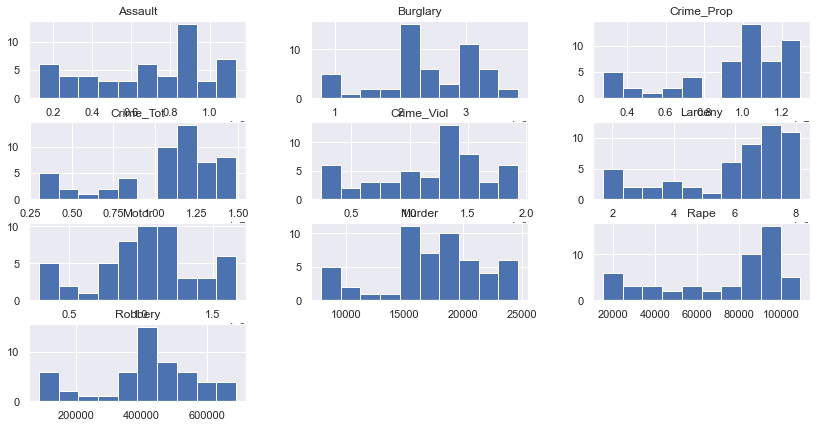

In [95]:
years_crime = states_crime.groupby('Year').sum()
crime_2011 = years_crime[years_crime.index == 2011]
_=years_crime.hist(figsize=(14, 7))

In [96]:
crime_2011

,Crime_Prop,Crime_Viol,Burglary,Larceny,Motor,Assault,Murder,Rape,Robbery,Crime_Tot
Year,,,,,,,,,,
2011,"9,052,743.00","1,206,031.00",2185140,6151095,716508,752423,14661,84175,354772,"10,258,774.00"


In [97]:
crime_2011_adj =crime_2011/year_econ['Population'].values[0]*100000
crime_2011_adj

,Crime_Prop,Crime_Viol,Burglary,Larceny,Motor,Assault,Murder,Rape,Robbery,Crime_Tot
Year,,,,,,,,,,
2011,"2,952.59",393.35,712.69,"2,006.20",233.69,245.41,4.78,27.45,115.71,"3,345.94"


In [98]:
states_crime = states_crime[(states_crime['Year'] == 2011)]
states_crime.set_index(['Year','State_Name'], inplace=True)
states_crime.sum()

Crime_Prop    9,052,743.00
Crime_Viol    1,206,031.00
Burglary      2,185,140.00
Larceny       6,151,095.00
Motor           716,508.00
Assault         752,423.00
Murder           14,661.00
Rape             84,175.00
Robbery         354,772.00
Crime_Tot    10,258,774.00
dtype: float64

In [99]:
states_crime = states_crime/states_econ['Population'].values[0]*100000
states_crime.head()

Crime_Prop  Crime_Viol  Burglary   Larceny    Motor  Assault  \
Year State_Name                                                                 
2011 Alabama       3,648.13      424.78  1,076.77  2,346.77   224.58   286.28   
     Alaska          402.20       93.02     60.07    312.89    29.24    71.07   
     Arizona       4,842.54      564.28  1,152.10  3,273.35   417.09   352.78   
     Arkansas      2,326.10      298.54    716.51  1,488.07   121.52   219.61   
     California   20,512.64    3,263.73  4,846.31 12,573.24 3,093.09 1,920.94   

                 Murder   Rape  Robbery  Crime_Tot  
Year State_Name                                     
2011 Alabama       6.30  28.86   103.34   4,072.90  
     Alaska        0.63   9.18    12.13     495.22  
     Arizona       8.36  52.64   150.50   5,406.83  
     Arkansas      3.37  25.91    49.65   2,624.64  
     California   37.75 161.46 1,143.59  23,776.37

In [100]:
states_crime.reset_index(inplace=True)
states_crime.to_csv("resources/crime_analysis.csv", encoding="utf-8", index=False)

* cdc_analysis.csv (Leading causes of Death) 

In [101]:
# Import data
states_deaths = pd.read_csv('resources/cdc_analysis.csv')
states_deaths.head()

,All causes,Alzheimer,CLRD,Cancer,Diabetes,Heart,Pneumonia,Kidney,Stroke,Suicide,Injuries,Geo,State
0,"1,025.42",31.30,61.34,215.55,26.92,251.55,20.03,22.05,54.09,13.78,56.07,South,Alabama
1,81.08,1.52,4.09,19.69,2.25,15.57,1.22,1.12,3.54,3.01,8.11,North,Alaska
2,"1,019.10",49.46,66.69,225.17,36.65,224.58,14.53,8.32,45.25,24.43,65.21,South,Arizona
3,624.61,21.11,41.81,136.85,19.13,150.99,15.31,16.58,35.64,9.73,31.81,South,Arkansas
4,"5,054.15",243.40,281.35,"1,189.04",162.09,"1,259.04",130.60,54.75,284.43,84.17,228.00,South,California


* creating common dataset for exploration

In [105]:
states_data = pd.merge(states_econ, states_crime, how='inner')
states_data_2011 = pd.merge(states_data, states_deaths, how='inner')
states_data_2011.to_csv("resources/states_2011.csv", encoding="utf-8", index=False)
states_data_2011.columns

Index(['State_Name', 'Year', 'Population', 'House_Income', 'Per_Cap_Income',
       'Pov_Rate', 'Unemp_Rate', 'Geo', 'Lat', 'Lng', 'Crime_Prop',
       'Crime_Viol', 'Burglary', 'Larceny', 'Motor', 'Assault', 'Murder',
       'Rape', 'Robbery', 'Crime_Tot', 'All causes', 'Alzheimer', 'CLRD',
       'Cancer', 'Diabetes', 'Heart', 'Pneumonia', 'Kidney', 'Stroke',
       'Suicide', 'Injuries', 'State'],
      dtype='object')

## Data Exploration
* 2011

In [10]:
# Extracting Data for 2011
expl_data_2011 = states_data[states_data['Year']==2011].filter(['Geo', 'Lat', 'Pov_Rate', 'Unemp_Rate', 'Per_Cap_Income',
                                                                'House_Income', 'Crime_Prop_Adj', 'Crime_Viol_Adj', 'Crime_Adj'])

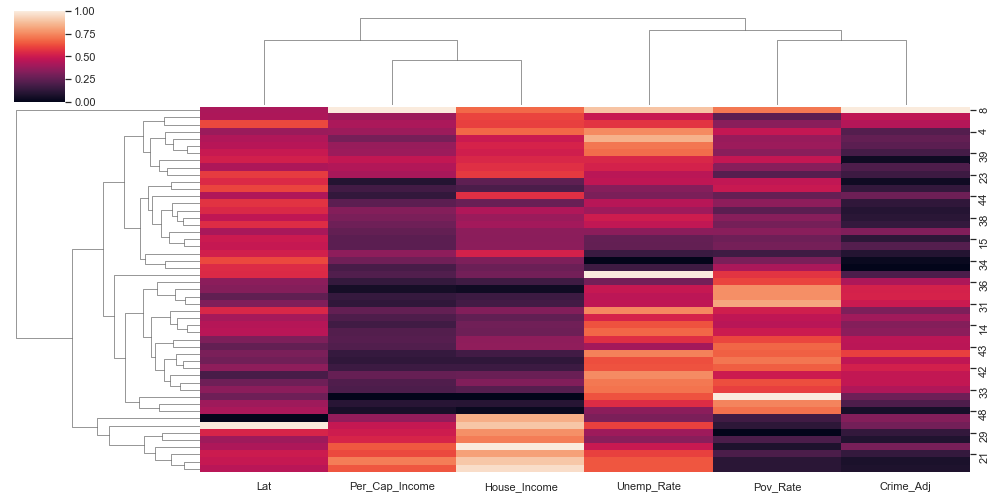

In [11]:
# Plot a hierarchically clustered heatmap
cluster_data = expl_data_2011.filter(['Pov_Rate', 'Lat', 'Unemp_Rate', 'Per_Cap_Income', 'House_Income', 'Crime_Adj'])
g = sns.clustermap(cluster_data, figsize=(14, 7), standard_scale=1)
plt.savefig('../images/dendrogram_2011.png')

In [12]:
# Correlation Matrix (Crime Adj Rate and Economic Indicators)
corr = expl_data_2011.corr()
print('Correlation Matrix, State Level, 2011')
corr.style.background_gradient(cmap='coolwarm')

Correlation Matrix, State Level, 2011


,Lat,Pov_Rate,Unemp_Rate,Per_Cap_Income,House_Income,Crime_Prop_Adj,Crime_Viol_Adj,Crime_Adj
Lat,1.000000,-0.451498,-0.107131,0.255678,0.261922,-0.498244,-0.161041,-0.452675
Pov_Rate,-0.451498,1.000000,0.295770,-0.583278,-0.797120,0.531410,0.352487,0.524317
Unemp_Rate,-0.107131,0.295770,1.000000,0.193028,0.057184,0.380437,0.478439,0.427287
Per_Cap_Income,0.255678,-0.583278,0.193028,1.000000,0.861788,-0.089936,0.312544,-0.003249
House_Income,0.261922,-0.797120,0.057184,0.861788,1.000000,-0.243375,0.049488,-0.191683
Crime_Prop_Adj,-0.498244,0.531410,0.380437,-0.089936,-0.243375,1.000000,0.655411,0.984839
Crime_Viol_Adj,-0.161041,0.352487,0.478439,0.312544,0.049488,0.655411,1.000000,0.776492
Crime_Adj,-0.452675,0.524317,0.427287,-0.003249,-0.191683,0.984839,0.776492,1.000000


In [13]:
# Correlation Matrix
states_deaths_2011_adj['Lat'] = states_data['Lat']
states_deaths_2011_adj['Crime_Adj'] = states_data['Crime_Adj']
states_deaths_2011_adj['Crime_Prop_Adj'] = states_data['Crime_Prop_Adj']
states_deaths_2011_adj['Crime_Viol_Adj'] = states_data['Crime_Viol_Adj']
corr = states_deaths_2011_adj.corr()
print('Correlation Matrix, State Level, 2011')
corr.style.background_gradient(cmap='coolwarm')

Correlation Matrix, State Level, 2011


Cause Name,All causes,Cancer,Heart,Pneumonia,Suicide,Injuries,Lat,Crime_Adj,Crime_Prop_Adj,Crime_Viol_Adj
Cause Name,,,,,,,,,,
All causes,1.000000,0.939342,0.886507,0.591834,0.021846,0.554600,-0.194911,-0.019115,0.000246,-0.084119
Cancer,0.939342,1.000000,0.835558,0.506632,-0.085363,0.381380,-0.081435,-0.075902,-0.065350,-0.093084
Heart,0.886507,0.835558,1.000000,0.676766,-0.228339,0.325274,-0.280166,0.029418,0.010999,0.088131
Pneumonia,0.591834,0.506632,0.676766,1.000000,-0.181850,0.203673,-0.291430,-0.154800,-0.171942,-0.049405
Suicide,0.021846,-0.085363,-0.228339,-0.181850,1.000000,0.659030,0.214722,-0.144351,-0.103518,-0.252460
Injuries,0.554600,0.381380,0.325274,0.203673,0.659030,1.000000,-0.000580,0.002160,0.030385,-0.100969
Lat,-0.194911,-0.081435,-0.280166,-0.291430,0.214722,-0.000580,1.000000,-0.452675,-0.498244,-0.161041
Crime_Adj,-0.019115,-0.075902,0.029418,-0.154800,-0.144351,0.002160,-0.452675,1.000000,0.984839,0.776492
Crime_Prop_Adj,0.000246,-0.065350,0.010999,-0.171942,-0.103518,0.030385,-0.498244,0.984839,1.000000,0.655411


                        Data exploration for 2011 year (Northern vs Southern States)


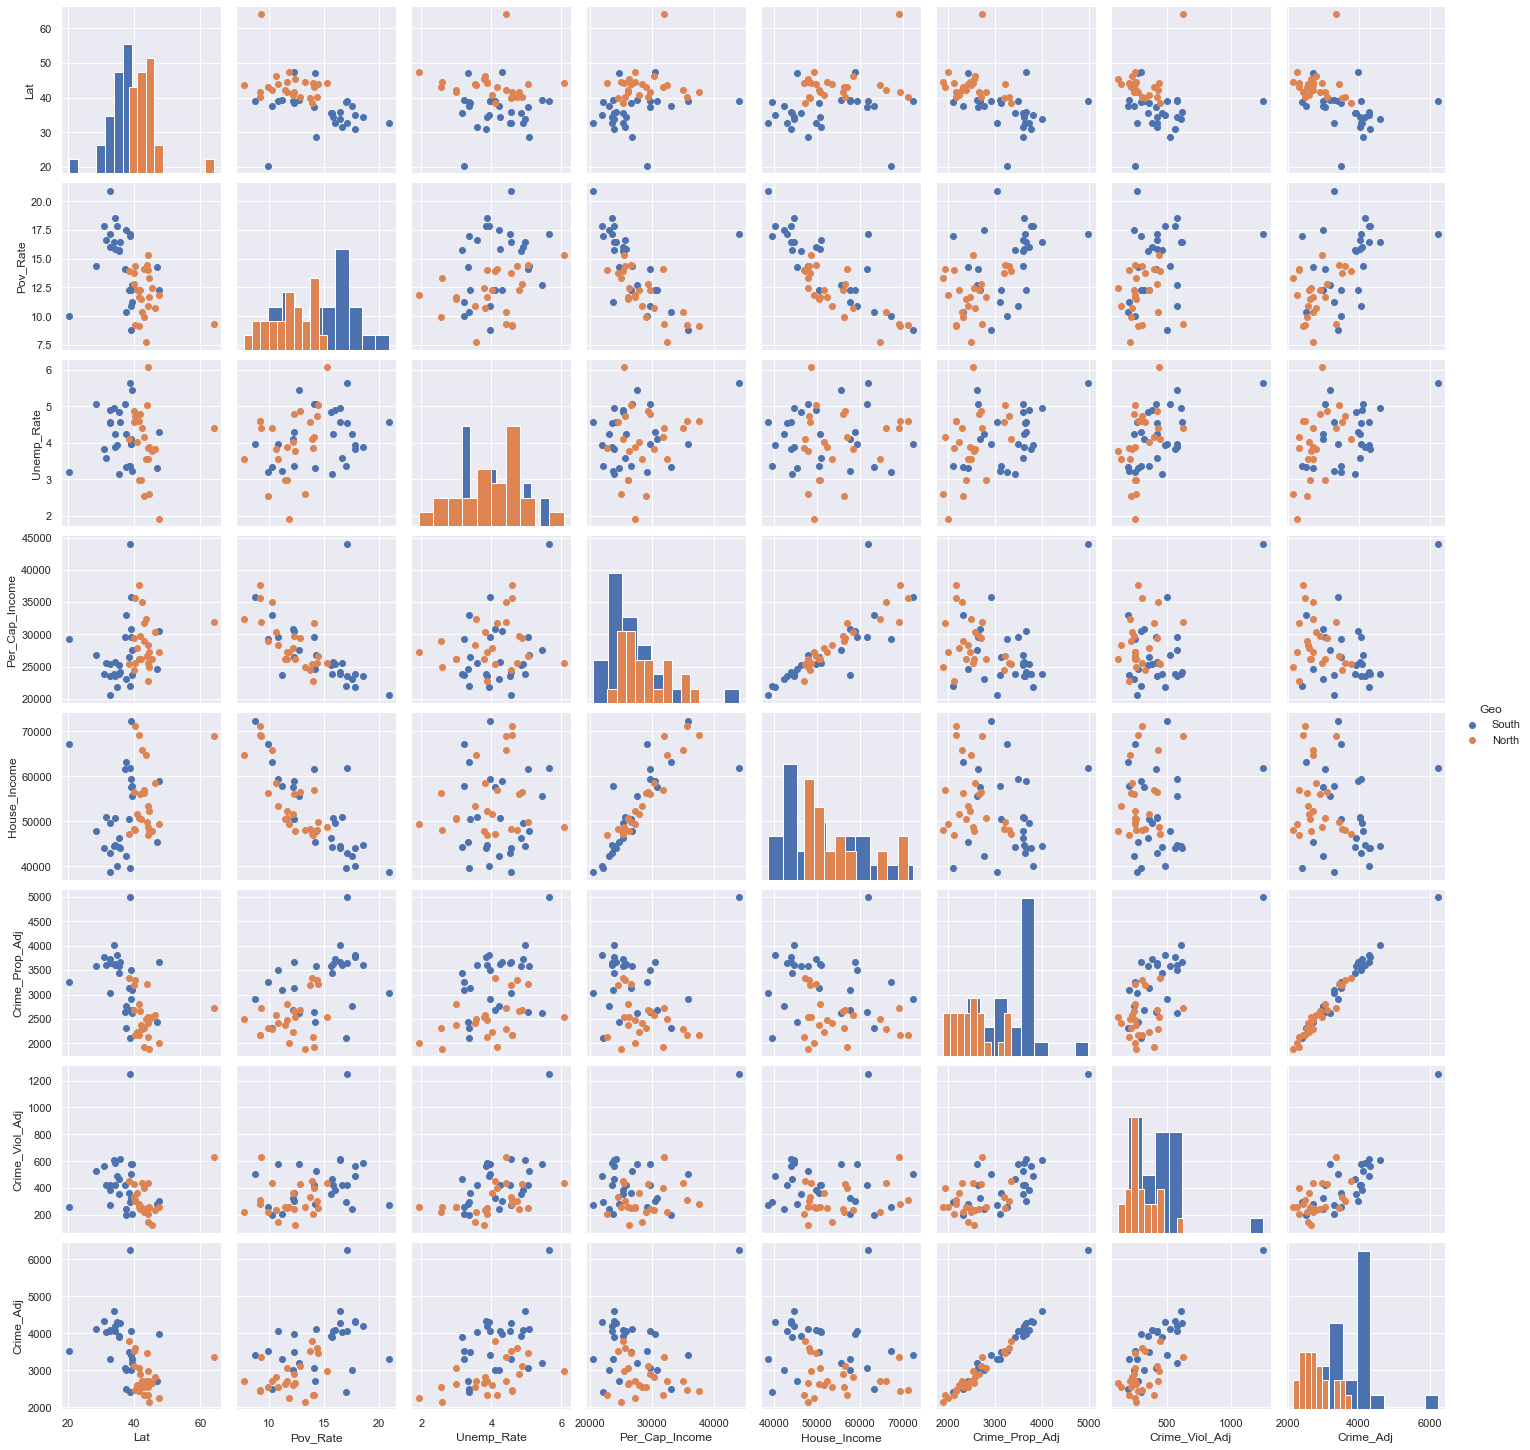

In [14]:
# Data Exploration for 2011
g=sns.PairGrid(expl_data_2011, hue='Geo')
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()
print(' '*23,'Data exploration for 2011 year (Northern vs Southern States)')
plt.savefig('images/exploration_2011.png')